In [1]:
import cartopy.crs as ccrs

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm, PowerNorm
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
import shapely

import geopandas
import numpy as np
import pyproj as prj
import os
import xarray

from osgeo import ogr

### Set the working directory and filename(s) containing the netcdf data to plot

In [20]:
work_dir = '../data'
filename = '{}/summary_daily_sample.nc'.format(work_dir)

In [21]:
def plot_polygon_collection(ax, geoms, values=None, colormap='Set1',  facecolor=None, edgecolor=None,
                            alpha=0.5, linewidth=1.0, **kwargs):
    """ Plot a collection of Polygon geometries """
    # from https://stackoverflow.com/questions/33714050/geopandas-plotting-any-way-to-speed-things-up
    patches = []

    for poly in geoms:

        a = np.asarray(poly.exterior)
        if poly.has_z:
            poly = shapely.geometry.Polygon(zip(*poly.exterior.xy))

        patches.append(Polygon(a))

    patches = PatchCollection(patches, facecolor=facecolor, linewidth=linewidth, edgecolor=edgecolor, alpha=alpha, **kwargs)

    if values is not None:
        patches.set_array(values)
        patches.set_cmap(colormap)

    ax.add_collection(patches, autolim=True)
    ax.autoscale_view()
    return patches

### Get extent and projection information from the shapefile or geodatabase

In [22]:
# ### Get extent information from the national HRUs shapefile

# Need two shapefiles 1) in projected coordinates, 2) in geographic coordinates
# If gdal is installed can create geographic coordinates from projected with:
#   ogr2ogr -t_srs epsg:4326 output_wgs84.shp input.shp

shpfile = '../GIS/all_nhru_simple_lcc/nhruNationalIdentifier.shp'

# Name of attribute to use. Change to match the name of the HRU id attribute in the shapefile
shape_key='hru_id_nat'

# Use gdal/ogr to get the extent information
# Shapefile can be in projected coordinates
# Driver can be: OpenFileGDB or ESRI Shapefile
inDriver = ogr.GetDriverByName("ESRI Shapefile")
inDataSource = inDriver.Open(shpfile, 0)
inLayer = inDataSource.GetLayer()
# inLayer = inDataSource.GetLayerByName('nhruNationalIdentifier')
extent = inLayer.GetExtent()

# Get the spatial reference information from the shapefile
spatial_ref = inLayer.GetSpatialRef()

# Create transformation object using projection information from the shapefile 
xform = prj.Proj(spatial_ref.ExportToProj4())

west, east, south, north = extent
pad = 100000.    # amount to pad the extent values with (in meters)
#east += pad
#west -= pad
#south -= pad
#north += pad

LL_lon, LL_lat = xform(west, south, inverse=True)
UR_lon, UR_lat = xform(east, north, inverse=True) 
print('\tExtent: ({0:f}, {1:f}, {2:f}, {3:f})'.format(west, east, south, north))
print('\tExtent: (LL: [{}, {}], UR: [{}, {}])'.format(LL_lon, LL_lat, UR_lon, UR_lat))

extent_dms = [LL_lon, UR_lon, LL_lat, UR_lat]

# Matplotlib basemap requires the map center (lon_0, lat_0) be in decimal degrees
# and yet the corners of the extent can be in projected coordinates
cen_lon, cen_lat = xform((east+west)/2, (south+north)/2, inverse=True)

print('cen_lon: {}'.format(cen_lon))
print('cen_lat: {}'.format(cen_lat))

	Extent: (-2226737.622750, 2123225.197338, -1591200.455402, 1552437.171930)
	Extent: (LL: [-118.1259488128116, 22.314742479004735], UR: [-63.56830830772724, 50.992795871083445])
cen_lon: -96.6433570426641
cen_lat: 39.81236755912492


In [23]:
print(spatial_ref)

PROJCS["North_America_Lambert_Conformal_Conic",
    GEOGCS["GCS_North_American_1983",
        DATUM["North_American_Datum_1983",
            SPHEROID["GRS_1980",6378137.0,298.257222101]],
        PRIMEM["Greenwich",0.0],
        UNIT["Degree",0.017453292519943295]],
    PROJECTION["Lambert_Conformal_Conic_2SP"],
    PARAMETER["False_Easting",0.0],
    PARAMETER["False_Northing",0.0],
    PARAMETER["Central_Meridian",-96.0],
    PARAMETER["Standard_Parallel_1",20.0],
    PARAMETER["Standard_Parallel_2",60.0],
    PARAMETER["Latitude_Of_Origin",40.0],
    UNIT["Meter",1.0]]


### Read the shapefile using geopandas

In [24]:
# Read the shapefile
hru_df = geopandas.read_file(shpfile)

### Read the netcdf file(s) with xarray

In [25]:
# Open the netcdf file of NHM output variables
xdf = xarray.open_mfdataset(filename, chunks={'nhru': 1040}, combine='by_coords')
xdf = xdf.set_index(nhru='nhm_id')

### Use .info() to see the contents of the netcdf file

In [26]:
xdf.info()

xarray.Dataset {
dimensions:
	nhru = 109951 ;
	nsegment = 56460 ;
	time = 51 ;

variables:
	float32 freeh2o(time, nhru) ;
		freeh2o:description = Storage of free liquid water in the snowpack on each HRU ;
		freeh2o:units = inches ;
	float32 hru_actet(time, nhru) ;
		hru_actet:description = Actual ET for each HRU ;
		hru_actet:units = inches ;
	float32 hru_ppt(time, nhru) ;
		hru_ppt:description = Precipitation distributed to each HRU ;
		hru_ppt:units = inches ;
	float32 hru_rain(time, nhru) ;
		hru_rain:description = Rain distributed to each HRU ;
		hru_rain:units = inches ;
	float32 hru_snow(time, nhru) ;
		hru_snow:description = Snow distributed to each HRU ;
		hru_snow:units = inches ;
	int32 intcp_on(time, nhru) ;
		intcp_on:description = Flag indicating interception storage for each HRU (0=no;1=yes) ;
		intcp_on:units = none ;
	float32 net_ppt(time, nhru) ;
		net_ppt:description = Precipitation (rain and/or snow) that falls through the canopy for each HRU ;
		net_ppt:units = inch

### Select the variable and timestep for plotting

In [27]:
# Set the variable to read from the netcdf dataset
the_var = 'net_ppt'

# Timestep by index for the variable
time_index = 2

### Next two cells select a colormap and use the min and max of data values to set the colormap range

In [28]:
# Create the colormap
if the_var in ['tmax_hru', 'tmin_hru']:
    cmap = 'RdBu_r'
elif the_var in ['net_ppt', 'net_rain', 'net_snow']:
    cmap = 'YlGnBu'
else:
    cmap = 'jet'

# create the colormap if a list of names is given, otherwise
# use the given colormap
lscm = mpl.colors.LinearSegmentedColormap
if isinstance(cmap,(list,tuple)):
    cmap = lscm.from_list('mycm', cmap)
else:
    cmap = plt.get_cmap(cmap)
    
missing_color = '#ff00cb'   # pink/magenta

In [29]:
# Get the min and max values for the variable
max_val = xdf[the_var].max(dim='time').max(dim='nhru').values
min_val = xdf[the_var].min(dim='time').min(dim='nhru').values

# norm = PowerNorm(gamma=0.05)
# norm = LogNorm(vmin=min_val, vmax=max_val)

if min_val == 0.:
    if the_var in ['net_ppt', 'net_rain', 'net_snow']:
        cmap.set_under(color='None')
        norm = LogNorm(vmin=0.000001, vmax=max_val)
    else:
        norm = Normalize(vmin=0.000001, vmax=max_val)
else:
    if the_var in ['tmax_hru', 'tmin_hru']:
        norm = Normalize(vmin=-max_val, vmax=max_val)
    else:
        norm = Normalize(vmin=min_val, vmax=max_val)

### Plot the variable for the given timestep
<P>The first plot takes longer to generate. Subsequent plots (below) are much faster</P>

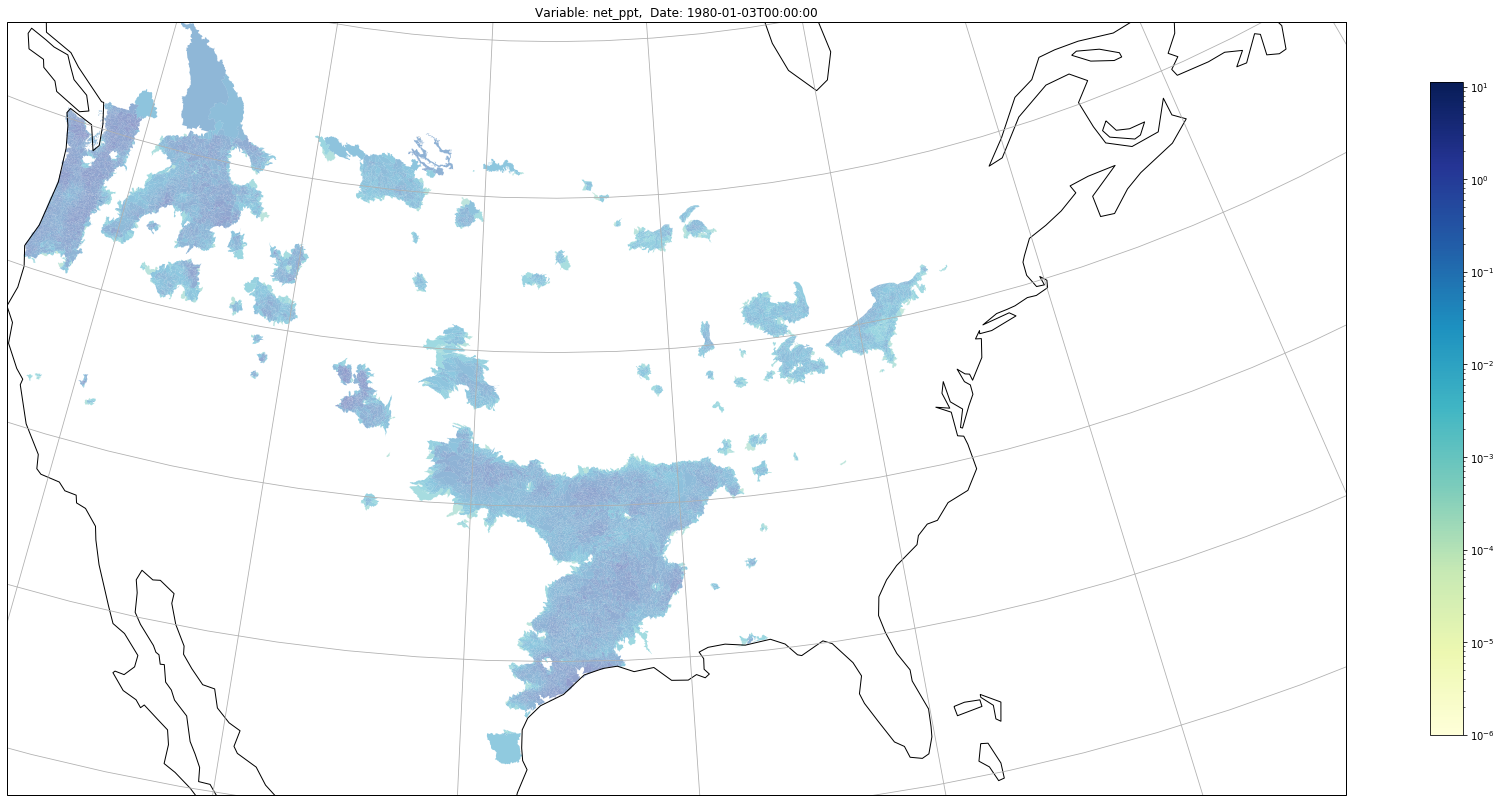

In [30]:
# Take care of multipolygons that exist in the NHM geodatabase/shapefile
geoms_exploded = hru_df.explode().reset_index(level=1, drop=True)

# Get a Pandas dataframe from the netcdf dataset for a single timestep
xdf_df = xdf[the_var][time_index].to_dataframe()

# Merge the variable data with the shapefile based on the national HRU ID
df_mrg = geoms_exploded.merge(xdf_df, left_on='hru_id_nat', right_index=True, how='left')

lcc_proj = ccrs.LambertConformal(central_latitude=40., standard_parallels=(20, 60))
# aea_proj = ccrs.AlbersEqualArea(central_longitude=-96., central_latitude=23., standard_parallels=(29.5, 45.5))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(30,20))

ax = plt.axes(projection=lcc_proj)
ax.coastlines()
ax.gridlines()
ax.set_extent(extent_dms)

mapper = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
mapper.set_array(df_mrg[the_var].values)
plt.colorbar(mapper, shrink=0.6)

plt.title('Variable: {},  Date: {}'.format(the_var, xdf_df['time'].iloc[0].isoformat()))

col = plot_polygon_collection(ax, df_mrg.geometry, values=df_mrg[the_var], colormap=cmap, norm=norm)

### Plot additional timestep(s)
<P>Change the time_index for each additional plot</P>

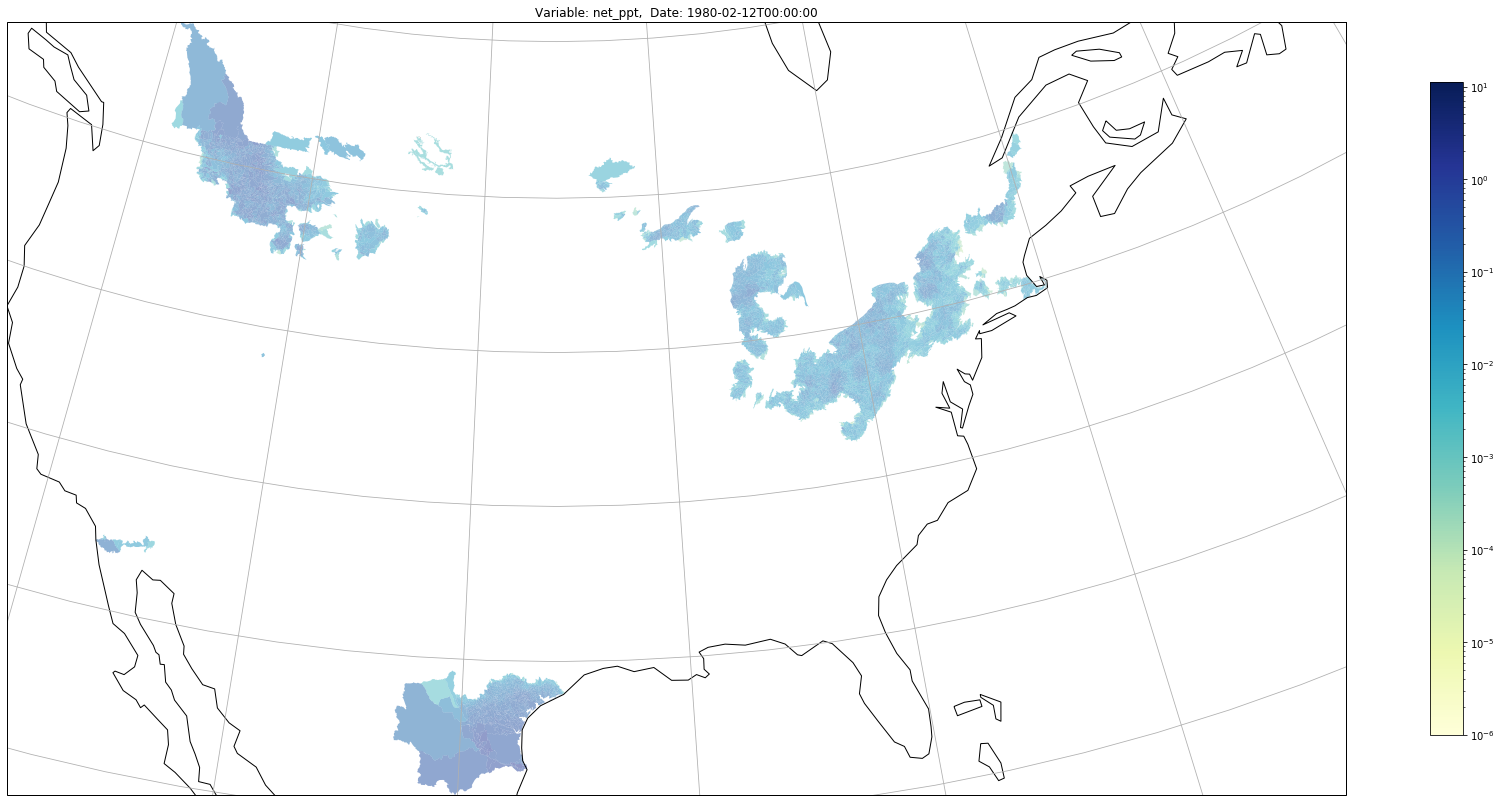

In [31]:
time_index = 42

xdf_df = xdf[the_var][time_index].to_dataframe()
df_mrg = geoms_exploded.merge(xdf_df, left_on='hru_id_nat', right_index=True, how='left')

ax.set_title('Variable: {},  Date: {}'.format(the_var, xdf_df['time'].iloc[0].isoformat()))
col.set_array(df_mrg[the_var])
fig